In [157]:
import numpy as np
import pandas as pd

"""
Comparison for network Lorenz stochastic dynamics inference

"""

# Import the package:

from StochasticForceInference import *

 

In [171]:
Aadj = pd.read_csv('/Users/lana_g/Downloads/comparison/Lorenz2nodesAdj.csv',encoding='utf-8',header=None)
A = Aadj.values

In [172]:
x_data = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_x_stochastic_gamma1.csv',encoding='utf-8',header=None)

In [173]:
T=100
dt=0.01
tlist=np.linspace(0.01,T,int(T/dt))

In [174]:
xlist = x_data.values.reshape(-1,20,3)
print("check:")
print(xlist.shape)

check:
(10000, 20, 3)


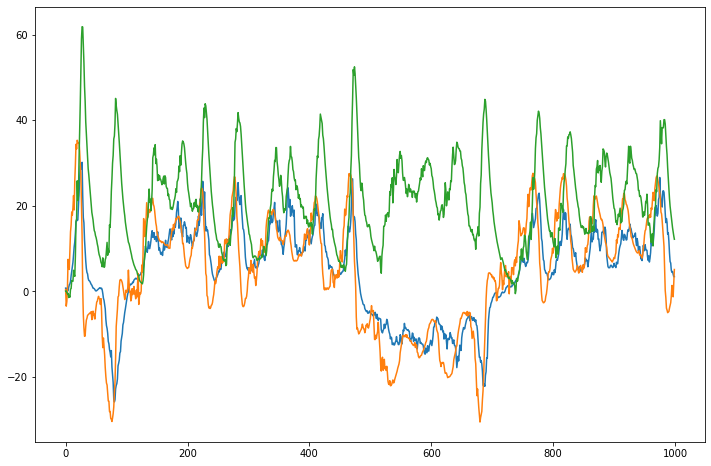

In [175]:
import matplotlib.pyplot as plt
plt.plot(xlist[:1000,1,:])

In [54]:
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
freq = 1
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])

20 3


In [55]:
################################################################
##### II. Perform SFI.                                    ######

S = StochasticForceInference(data)  


# Choose the radial kernels with which to fit the pair interaction -
# here Npts Gaussians
r0 = 2.
Rmax = 10
Npts = 5
sigma=2.
def Gaussian_kernel(sigma,r0):
    # Factory to limit the scope of k
    return lambda r : np.exp(-(r-r0)**2/(2*sigma))
kernels = [ Gaussian_kernel(sigma,r0) for r0 in np.linspace(0,Rmax,Npts) ]

S.compute_drift(
    basis={ 'type' : 'self_propelled_particles', 'order' : 1, 'kernels' : kernels , 'adjmatrix' : A},\
    diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
    #diffusion_mode = 'constant',   
    #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
    #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
    #mode='Ito'  # Use only for noise-free data.
) 

S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 0}
) 


S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[104.77900381  17.51340453  -2.56601141]
 [ 17.51340453 136.42105213  -0.19514638]
 [ -2.56601141  -0.19514638 191.3517988 ]]
Entropy production: inferred/bootstrapped error 102747.57921982021 462.1635624317871
Drift information: inferred/bootstrapped error 21940.35853914586 210.68214703266082
Drift: squared typical error on projections: 0.00512478708559141
  - due to trajectory length: 0.0010255073981519324
  - due to discretization: 0.004099279687439478
Diffusion: squared typical error on projections: 0.1926737859379532
  - due to trajectory length: 4.5009001800360075e-05
  - due to discretization: 0.0
  - due to drift: 0.19262877693615285


In [178]:
data_exact = StochasticTrajectoryData(xlist,tlist)
print(data_exact)
F_exact = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz_F_stochastic_gamma1.csv',encoding='utf-8',header=None)
F_exact1 = F_exact.values[1:-1].reshape(-1,20,3)
#S.compare_to_exact(data_exact=data_exact,force_exact=F_exact)


1 3


In [179]:
indices = np.array([i for i in range(0,len(tlist)-2,1)])
ansatz_F_Ito  = [ S.F_ansatz(data.X_ito[i]) for i in indices ]

Text(0, 0.5, 'inferred F_mu(x)')

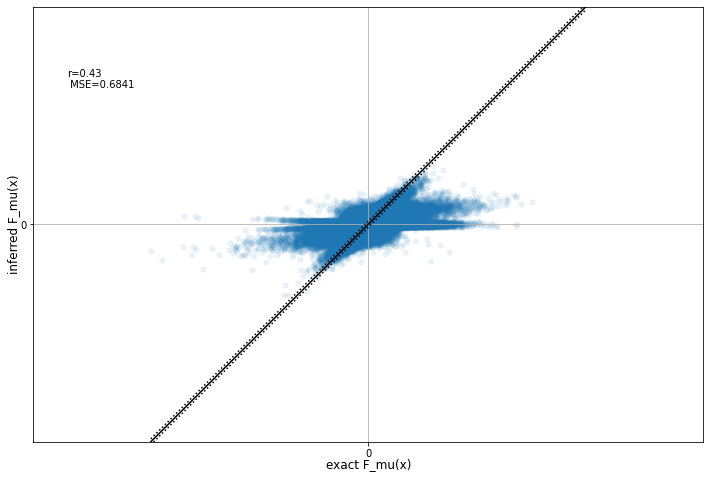

In [67]:
SFI_plotting_toolkit.comparison_scatter(F_exact,ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel('exact F_mu(x)',labelpad=-1)
plt.ylabel('inferred F_mu(x)',labelpad=0)

In [116]:
ansatz_F_Ito[0][0]

array([ 13.88731984, -38.47666128, -17.32548866])

In [110]:
npdata=np.array(ansatz_F_Ito).reshape(-1,20*3)

In [117]:
ygoal = ansatz_F_Ito[0][0]
for i in range(20):
    for t in range(npdata[:].shape[0]):
        tmp = ansatz_F_Ito[t][i]
        ygoal = np.vstack((ygoal,tmp))

In [139]:
from ElementaryFunctionsPool import *
from ElementaryFunctions_Matrix import *

In [140]:
A = pd.read_csv('/Users/lana_g/Downloads/comparison 2/Lorenz2nodesAdj.csv',encoding='utf-8',header=None)
A = A.values

In [141]:
data = x_data.values[1:-1,:]

In [142]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     print(reg.coef_)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [143]:
Dim=3
Nnodes = 20
selfPolyOrder = 3
Matrix = ElementaryFunctions_Matrix(data, Dim, Nnodes, A, selfPolyOrder, coupledPolyOrder = 1, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False, RescalingIndex = False, CoupledPolynomialIndex = True, \
        CoupledTrigonometricIndex = True, CoupledExponentialIndex = False, CoupledFractionalIndex = False, \
            CoupledActivationIndex = False, CoupledRescalingIndex = False)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [144]:
X = Matrix.copy()
y = ygoal[1:,:].copy()
X_mat = X.values 
y_mat = ygoal[1:,:]
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 3
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)

y1 = (out[:,2])

In [145]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(np.float64(Xin),np.float64(y1))
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


0.6971582432131944
Best threshold: 0.010


/Applications/anaconda3/envs/tf_new/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LassoCV was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [146]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 without constant.
expx1             1.000000e-10
x1x3x3            2.171020e-04
x1x1x2           -1.601895e-03
x1j               4.024445e-03
x2x3             -8.622224e-03
x2jMinusx2i       9.065014e-02
sinx1jMinusx1i   -2.050309e-01
sinx3j           -1.096215e+00
x1                5.349548e+00
x2               -5.651689e+00
dtype: float64


In [177]:
import numpy as np
import pandas as pd
"""

A demo of Stochastic Force Inference, on the example of the stochastic
Lorenz process.

"""

# Import the package:
from StochasticForceInference import *

 
################################################################
##### I. Prepare the data (here using a simulated model). ######


# Diffusion parameters: a linear diffusion gradient (multiplicative noise)
dim=3
diffusion_coeff = 0.1
D = diffusion_coeff *  np.identity(dim) 
y = np.array([1.,2,1])
D = lambda X : np.array([ np.identity(dim) + (np.einsum('m,n->mn',x,y)+np.einsum('m,n->mn',y,x))*0.05 for x in X ])


# Force field parameters (stochastic Lorenz process)
r,b,s = 6.,1.,3.

# force = lambda X : np.array([[ s*(x[2]-x[0]),
#                                x[0]*x[2]-b*x[1],
#                                r*x[0] - x[2] - x[1]*x[0]] for x in X ])

# force = lambda X : np.array([[ 3*(x[1]-x[0]), 
#                                 26.5*x[0]-x[1]-x[0]*x[2], 
#                                 x[0]*x[1]-0.16*x[2] ]for x in X])

# # Note: the "for" loop runs over particles/copies of the simulation;
# #   it is not used here.

# # Simulation parameters
# initial_position = np.array([[0.1 for i in range(dim)]]) 
dt = 0.01
oversampling = 4
# #prerun = 100
Npts = 10000
# tau = dt * Npts
# tlist = np.linspace(0.,tau,Npts)

# # Run the simulation using our OverdampedLangevinProcess class
# np.random.seed(1)
# X = OverdampedLangevinProcess(force,D,tlist,initial_position=initial_position,oversampling=oversampling)

# # Possibly blur a bit the data to mimic noise from the measurement
# # device:
# noise_amplitude = 0.0
# noise = noise_amplitude * np.random.normal(size=X.data.shape)

# # The input of the inference method is the "xlist" array, which has
# # shape Nsteps x 1 x dim (the middle index is used for multiple
# # particles with identical properties; we do not use it in this demo).
# xlist = X.data + noise
# tlist = X.t
xlist = xlist[:,0,:].reshape(-1,1,3)
print(xlist)
print(tlist)
print(xlist.shape, tlist.shape)


#field_data.to_csv('field_Lorenz_x.csv')

# You can replace "xlist" and "tlist" by your own data!

# Motion blur simulator:
#xlist = (0.5*(X.data[1:] + X.data[:-1]) + noise[:-1])
#tlist = (X.t[:-1])


freq = 1
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = StochasticTrajectoryData(xlist[::freq],tlist[::freq])   #[start:stop:step]
center = data.X_ito.mean(axis=(0,1)) 
width  =  2.1 * abs(data.X_ito-center).max(axis=(0,1)) 



################################################################
##### II. Perform SFI.                                    ######


S = StochasticForceInference(data)  

S.compute_drift(basis = { 'type' : 'polynomial', 'order' : 2} ,
                #basis = { 'type' : 'Fourier', 'order' : 3, 'center' : center, 'width' : width, } ,
                #diffusion_mode = 'WeakNoise',  # Best for space-dependent noise with large dt
                diffusion_mode = 'MSD',        # Best for space-dependent noise with short trajectories
                #diffusion_mode = 'constant',   
                #diffusion_mode = 'Vestergaard', # Best for space-dependent noise with large measurement error 
                #mode='Ito'
) 


S.compute_diffusion(
    #method='Vestergaard',
    method='MSD',
    #method='WeakNoise',
    basis = { 'type' : 'polynomial', 'order' : 1}
) 

S.compute_force()
S.compute_drift_error() 
S.compute_diffusion_error()
S.compute_entropy()

S.print_report()

#data_exact = StochasticTrajectoryData(X.data,X.t)

[[[ 0.41379   0.33511   0.61131 ]]

 [[ 0.37192   2.2418    0.56233 ]]

 [[ 0.52711   2.0482    0.069069]]

 ...

 [[20.716    12.015    31.95    ]]

 [[20.135    11.011    33.749   ]]

 [[15.833     9.3699   33.409   ]]]
[1.000e-02 2.000e-02 3.000e-02 ... 9.998e+01 9.999e+01 1.000e+02]
(10000, 1, 3) (10000,)
1 3
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[110.03967014  23.47561479 -10.57670029]
 [ 23.47561479 174.46555637  -1.24292758]
 [-10.57670029  -1.24292758 217.58877123]]
Entropy production: inferred/bootstrapped error 34603.48888267095 269.8276816142886
Drift information: inferred/bootstrapped error 5521.210595485798 106.14810969099543
Drift: squared typical error on projections: 0.015155612575148098
  - due to trajectory length: 0.0027167954818213534
  - due to discretization: 0.012438817093326745
Diffusion: squared typical error on projections: 4.882985358970337
  - due to trajectory length: 0.0036007201440288058
  - due to discretiza

In [182]:
F_exact1 = F_exact.values[1:-1,:3].reshape(-1,1,3)

Text(0, 0.5, 'inferred F_mu(x)')

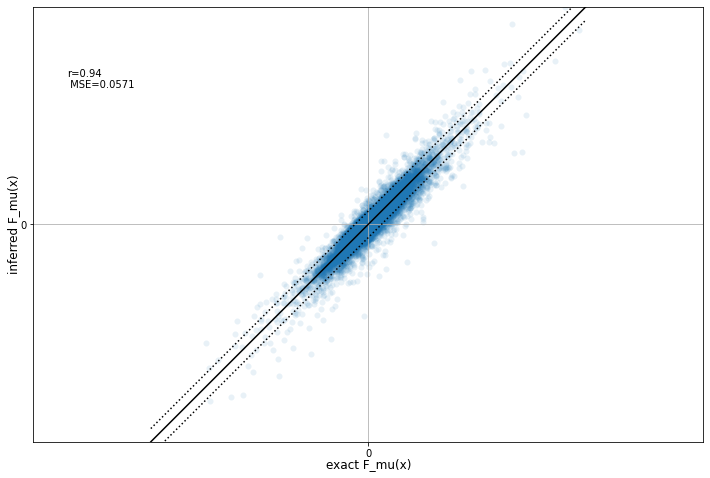

In [183]:
SFI_plotting_toolkit.comparison_scatter(F_exact1,ansatz_F_Ito,alpha=0.1,y=0.8,error=S.drift_projections_self_consistent_error**0.5)
plt.xlabel('exact F_mu(x)',labelpad=-1)
plt.ylabel('inferred F_mu(x)',labelpad=0)